In [9]:
import numpy as np
import pandas as pd
import six
import tensorflow as tf
import time
import os
from tqdm import tqdm

import random
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras

%matplotlib inline

In [22]:
DATA_PATH = 'data/outputs/name_price_desc.csv'
df_name_price_desc = pd.read_csv(DATA_PATH, sep='|', low_memory=False)
print(df_name_price_desc.shape)
df_name_price_desc.head()

(15549, 3)


,name,price,description
0,Hall Napa Valley Cabernet Sauvignon 2013,[54.99],"Dark garnet in color, the 2013 HALL Napa Valle..."
1,Rombauer Chardonnay 2017,[36.99],Rombauer Vineyards was founded in 1982 by Koer...
2,Antinori Tignanello 2015,[124.99],#24
3,Borne of Fire Cabernet Sauvignon 2016,[19.99],"Like a phoenix rising from the ashes, we have ..."
4,Torbreck Woodcutters Shiraz 2017,[21.99],This wine reflects the up and coming Shiraz vi...


In [38]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = df_name_price_desc['description'].astype(str)
# create the tokenizer
t = Tokenizer(num_words=5000)
# fit the tokenizer on the documents
t.fit_on_texts(docs)
	
encoded_docs = t.texts_to_matrix(texts=docs, mode='count')

In [39]:
encoded_docs.shape

(15549, 5000)

# TODO

### Figure out how to put tokenized (onehot data) into the embedding layer for price prediction

In [3]:
EMBEDDING_DIM = 512

def pricing_model(seq_len=100, batch_size=None, stateful=True):
    """Language model: predict the next word given the current word."""
    source = tf.keras.Input(
        name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    conv_1 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding)
    maxp_1 = tf.keras.layers.MaxPool1D(pool_size=2)(conv_1)
    flat_1 = tf.keras.layers.Flatten()(maxp_1)
    dens_1 = tf.keras.layers.Dense(units=10, activation='relu')(flat_1)
    price = tf.keras.layers.Dense(units=1)(dens_1)
    #drop_1 = tf.keras.layers.Dropout(0.2)
    model = tf.keras.Model(inputs=[source], outputs=[price])
    #model = tf.keras.utils.multi_gpu_model(model, gpus=2)

    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
        #optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
        loss='mean_squared_error',
        metrics=['mse'])
    return model

tf.keras.backend.clear_session()

training_model = pricing_model(seq_len=100, batch_size=1024, stateful=False)
#training_model.load_weights('model_small_chkpt.h5', by_name=True)

checkpoint = ModelCheckpoint('data/models_weights/model_char_DESCS_chkpt_old.h5', 
                             monitor='sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
early_stopping = EarlyStopping(monitor='sparse_categorical_accuracy',
                               patience=3,
                               mode='max')
callbacks_list = [checkpoint,early_stopping]

In [4]:
training_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (1024, 100)               0         
_________________________________________________________________
embedding (Embedding)        (1024, 100, 512)          131072    
_________________________________________________________________
lstm (LSTM)                  (1024, 100, 512)          2099200   
_________________________________________________________________
lstm_1 (LSTM)                (1024, 100, 512)          2099200   
_________________________________________________________________
time_distributed (TimeDistri (1024, 100, 256)          131328    
Total params: 4,460,800
Trainable params: 4,460,800
Non-trainable params: 0
_________________________________________________________________


In [6]:

training_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')

In [ ]:
# list all data in history
import matplotlib.pyplot as plt

training_acc = training_model.history.history['sparse_categorical_accuracy']
plt.figure(dpi=150)
plt.title("Accuracy per Epoch")
plt.plot(range(len(training_acc)),  training_acc)
plt.show()

## Create BASIC wine DESCRIPTION list

In [23]:
BATCH_SIZE = 5
PREDICT_LEN = 350

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')

# We seed the model with our initial string, copied BATCH_SIZE times

seed_txt = 'This wine tastes like '
seed_txt = ''.join(random.choices(string.ascii_uppercase + string.digits, k=20))
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

# Now we can accumulate predictions!
predictions = [seed[:, -1:]]
for i in range(PREDICT_LEN):
    last_word = predictions[-1]
    next_probits = prediction_model.predict(last_word)[:, 0, :]
  
  # sample from our output distribution
    next_idx = [
        np.random.choice(256, p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    predictions.append(np.asarray(next_idx, dtype=np.int32))
    
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'

PREDICTION 0


Y. The story is best known for its award-winnine experienced from all other vintage Champagne to unfold. As orphorng, Garnacha, Toro, Alivation that connoisseurs, as is the marriage of dried blynd sites, the wine is fruity, there is pleasant flavors of  plum fruits, jammavors, and a tea-leaf as thewine wild strawberry and raspberry flavors with a t

PREDICTION 1


Y. The vineyards are nestled about this Pinot noir and Cabernet Sauvignon and 2001. Laura blend offers complex nuances of apple flavors to a rivetting potential, intense depth and depth together toward almost hillside parcel above the earth and thanks to who introduce bears son, whole cluster (Armanding 200-acre estate located in Clavender, the REE

PREDICTION 2


Y.
This bold Andalt was from his honored tradition and innovation in New Zealand winemaking. Villa naturally in the Napa Valley and intesticing bold growing conditions.

Shrounded by the 92-acre Tigson to whom bust to Napa Valley, and provides the fir

## Create BIG fake wine DESCRIPTION list

In [97]:
seed.shape

(5, 36)

In [8]:
gen_conc

'\n\nA wine of breathtaking aromas of dark berries and wild strawberries in a New World sunshine  Tangerine, the stone savor, our nose, blackberry and fruit with notes of lime, and sweet honey, featurous balsam, slightly more slightly amber over a strict and moment throughout \nDeep violet-black Signorello Cru Capine e not much keptn alcohol  Drinks   This Pinot flavor pairs well, with rich mint and the fruit and flows black fruits, pineapple, cinnamon, and cinnamon spice.'

In [10]:
BATCH_SIZE = 1
PREDICT_LEN = 600
N_PREDICTIONS = 100

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')
predicted_names = pd.read_csv('data/outputs/NAMES_v1.csv')

N_PREDICTIONS = len(predicted_names)

fake_NAME = []
fake_DESC = []
for ii in tqdm(range(N_PREDICTIONS)):
    # We seed the model with our initial string, copied BATCH_SIZE times
    #seed_array = np.zeros(shape=(BATCH_SIZE,))
    for i in range(BATCH_SIZE):
        seed_txt = predicted_names['name'][ii+i]
        seed = transform(seed_txt)
        #print(seed.shape)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

    # First, run the seed forward to prime the state of the model.
    prediction_model.reset_states()
    for i in range(len(seed_txt) - 1):
        prediction_model.predict(seed[:, i:i + 1])

    # Now we can accumulate predictions!
    predictions = [seed[:, -1:]]
    for i in range(PREDICT_LEN):
        last_word = predictions[-1]
        next_probits = prediction_model.predict(last_word)[:, 0, :]

      # sample from our output distribution
        next_idx = [
            np.random.choice(256, p=next_probits[i])
            for i in range(BATCH_SIZE)
        ]
        predictions.append(np.asarray(next_idx, dtype=np.int32))

    for i in range(BATCH_SIZE):
        #print('PREDICTION %d\n\n' % i)
        p = [predictions[j][i] for j in range(PREDICT_LEN)]
        generated = ''.join([chr(c) for c in p])
        #print(generated)
        #print()
        gen_list = generated.split('.')[1:-1]
        gen_conc = ' '.join(gen_list) + '.'
        fake_NAME.append(seed_txt)
        fake_DESC.append(gen_conc)

pd.DataFrame({'name'        : fake_NAME,
              'description' : fake_DESC})\
    .to_csv('data/outputs/DESC_v1_2.csv', index=False, sep='|')

100%|█████████████████████████████████████████| 1275/1275 [45:44<00:00,  2.10s/it]


In [14]:
pd.DataFrame({'name'        : fake_NAME,
              'description' : fake_DESC}).head()

,name,description
0,Joseph Carr Reveliste Cinsault 2013,\n\nRaisage a trip back in time at the Frank F...
1,Carol Shelton Roche TBredi 2016,\nAromatics of this wine transporm nine expre...
2,Finca Bolgheri Pinot Grigio 2018,"This makes this opened scents, small whitehal..."
3,Domaine de Cristict Chardonnay 2016,"\nDigest boasts an intensity, or gift W This..."
4,Domaine Dujac Fils &amp; Pere Chambolle Rouge ...,"On the nose, aromas of grapefruit, lime and a..."


TypeError: list indices must be integers or slices, not str

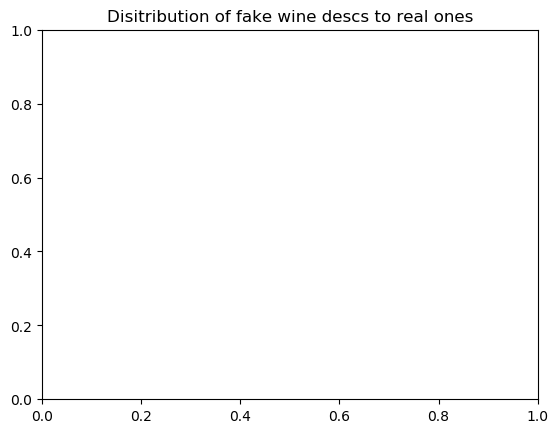

In [15]:
import matplotlib.pyplot as plt
plt.style.use('default')

plt.figure(dpi=100)
plt.title('Disitribution of fake wine descs to real ones')
plt.hist(fake_DESC['Score'])
plt.show()

In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

real_names, descs_raw = pd.read_pickle(DATA_PATH)
fake_scores = {}
for f_name in tqdm(fake_names):
    max_score = 0.0
    for r_name in descs_raw:
        if similar(f_name,r_name) > max_score:
            max_score = similar(f_name,r_name)
    fake_scores[f_name] = max_score
        

## OLD

In [ ]:
BATCH_SIZE = 5
PREDICT_LEN = 250

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('/tmp/bard.h5')

# We seed the model with our initial string, copied BATCH_SIZE times

seed_txt = 'Looks it not like the king?  Verily, we must go! '
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

# Now we can accumulate predictions!
predictions = [seed[:, -1:]]
for i in range(PREDICT_LEN):
    last_word = predictions[-1]
    next_probits = prediction_model.predict(last_word)[:, 0, :]
  
  # sample from our output distribution
    next_idx = [
        np.random.choice(256, p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    predictions.append(np.asarray(next_idx, dtype=np.int32))
    
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'